[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TheOctoMizer/AAI-510-Project/blob/main/EDAEnglish.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
tqdm.pandas()

In [3]:
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

In [4]:
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

In [5]:
DATASET_PATH = 'Datasets/final/multilingual_sentiment_195k.csv'
df = pd.read_csv(DATASET_PATH)

In [6]:
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (194997, 3)


In [7]:
# df = df.groupby('label', group_keys=False).apply(
#     lambda x: x.sample(frac=0.05, random_state=42)
# ).reset_index(drop=True)
# print(f"Dataset reduced to 40% of each sentiment's original size. New shape: {df.shape}")

In [8]:
print(df.head())

                                                text     label language
0  Que daora acho que meu título foi cancelado :)...  positive       pt
1  Ok je ferai cela aussi, j'aurai une lecture de...  positive       fr
2  Mes cheveux sont éloquents! -___- je me sens c...  positive       fr
3  @cutesvantae @BTS_twt YAAAA :(((( eu amo demai...  negative       pt
4  Pourquoi pensez-vous que vous avez vécu en Aus...  negative       fr


In [9]:
print(df.isnull().sum())

text        1
label       0
language    0
dtype: int64


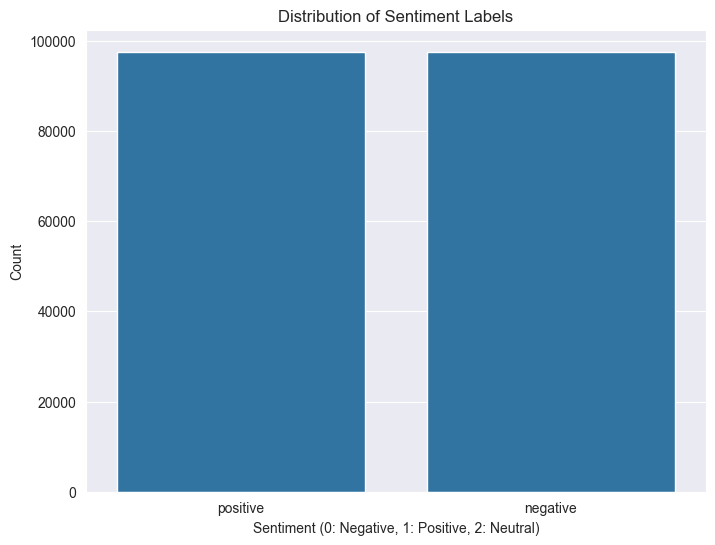

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Count')
plt.show()

In [11]:
df['text_length'] = df['text'].astype(str).str.len()
df['word_count'] = df['text'].astype(str).str.split().str.len()

In [12]:
print("Text Length Statistics:")
print(df.groupby('label')['text_length'].describe())

Text Length Statistics:
            count        mean        std  min   25%   50%    75%    max
label                                                                  
negative  97579.0  100.119185  73.998338  4.0  45.0  78.0  134.0  876.0
positive  97418.0   99.551972  70.280546  1.0  46.0  80.0  134.0  814.0


In [13]:
print("\nWord Count Statistics:")
print(df.groupby('label')['word_count'].describe())


Word Count Statistics:
            count       mean        std  min  25%   50%   75%    max
label                                                               
negative  97579.0  17.892948  13.001309  1.0  8.0  14.0  24.0  106.0
positive  97418.0  17.278480  12.309894  0.0  8.0  14.0  24.0  104.0


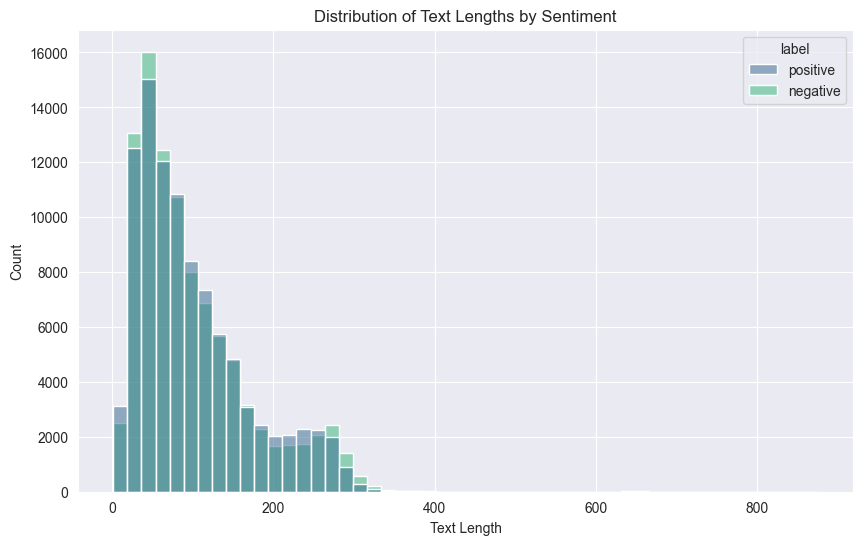

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, palette='viridis')
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

In [15]:
def safe_detect_language(text):
    """Safely detect language, returning 'unknown' on error or for empty text."""
    try:
        if isinstance(text, str) and text.strip():
            return detect(text)
        else:
            return 'unknown'
    except LangDetectException:
        return 'unknown'

In [16]:
def clean_text_phase1(text):
    """
    Initial text cleaning: lowercase, remove URLs, mentions, special characters, and digits.
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only alphabetic chars and spaces
    text = re.sub(r'\d+', '', text) # Remove digits
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with a single one
    return text

In [17]:
STOP_WORDS_ENGLISH = set(stopwords.words('english'))
STOP_WORDS_FRENCH = set(stopwords.words('french'))
STOP_WORDS_PORTUGUESE = set(stopwords.words('portuguese'))
EXTRA_STOPWORDS = {
    'cest', 'est', 'vous', 'que', 'qui', 'voce', 'muito', 'pra', 'mais',
    'sera', 'ta', 'vai', 'vou', 'pas', 'trop', 'etait', 'comme', 'avec',
    'tous', 'todas', 'tudo', 'ai', 'aqui', 'tem', 'porque', 'mais',
    'aime', 'ja', 'fait', 'faites', 'faites', 'fait', 'bon', 'bien'
}


In [18]:
all_stopwords = STOP_WORDS_ENGLISH.union(STOP_WORDS_FRENCH, STOP_WORDS_PORTUGUESE, EXTRA_STOPWORDS)
def remove_stopwords_from_tokens(text_cleaned):
    """
    Tokenizes text, removes multilingual stopwords, and filters for non-alphabetic tokens.
    """
    if not text_cleaned or pd.isna(text_cleaned):
        return ""  # Return empty string for empty/NaN input

    tokens = word_tokenize(text_cleaned)
    filtered_tokens = [
        word for word in tokens if word.isalpha() and word.lower() not in all_stopwords
    ]
    return ' '.join(filtered_tokens)


In [19]:
df['text_clean'] = df['text'].progress_apply(clean_text_phase1)

100%|██████████| 194997/194997 [00:00<00:00, 202594.06it/s]


In [20]:
df.dropna(subset=['text_clean', 'label'], inplace=True)
df_english = df[df['text_clean'].str.strip().astype(bool)]
df_english.reset_index(drop=True, inplace=True)

In [21]:
df_final_cleaned = df_english[['text_clean', 'label']].copy()

In [22]:
print(f"Final dataset shape: {df_final_cleaned.shape}")

Final dataset shape: (194978, 2)


In [23]:
print("Final value counts (proportional):")
print(df_final_cleaned['label'].value_counts(normalize=True))
print("\nFirst 5 rows of cleaned data:")
print(df_final_cleaned.head())

Final value counts (proportional):
label
negative    0.500462
positive    0.499538
Name: proportion, dtype: float64

First 5 rows of cleaned data:
                                          text_clean     label
0         que daora acho que meu ttulo foi cancelado  positive
1  ok je ferai cela aussi jaurai une lecture de l...  positive
2  mes cheveux sont loquents je me sens comme un ...  positive
3  yaaaa eu amo demais ver o seok se alimentando ...  negative
4  pourquoi pensezvous que vous avez vcu en austr...  negative


In [24]:
sentiment_labels = {'negative': 'Negative', 'positive': 'Positive'}

In [25]:
def generate_wordcloud(text_data, title):
    """Generates and plots a word cloud from the given text data."""
    text = ' '.join(text_data)
    if not text:
        print(f"No text data to generate word cloud for {title}.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        stopwords=all_stopwords,
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

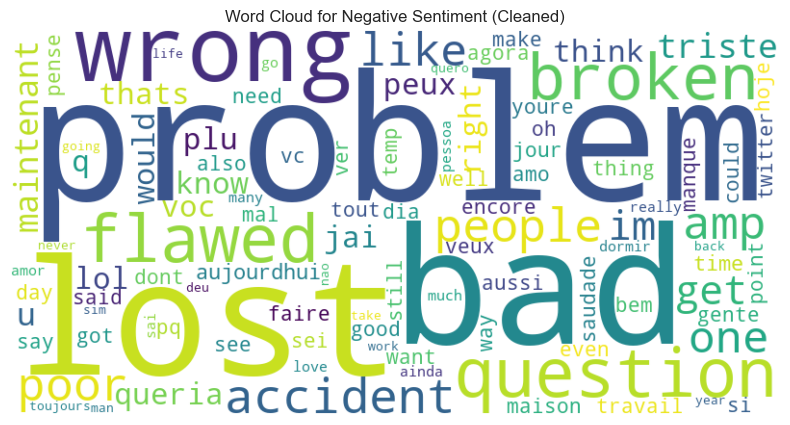

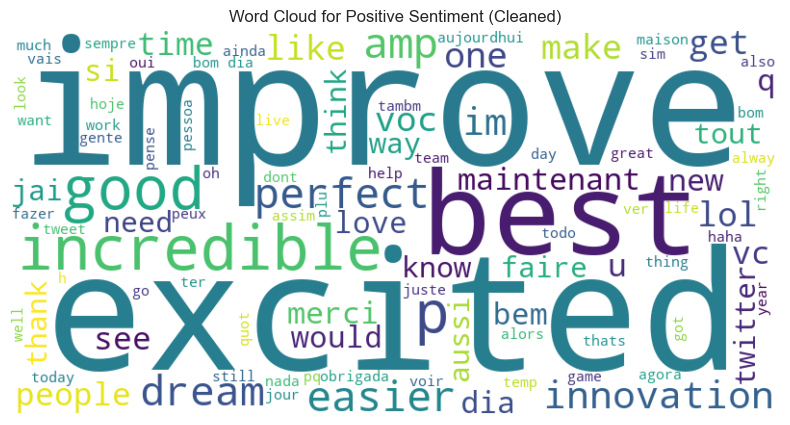

In [26]:
for label, sentiment in sentiment_labels.items():
    text_data = df_final_cleaned[df_final_cleaned['label'] == label]['text_clean'].dropna()
    if text_data.empty:
        print(f"No text data to generate word cloud for {label}.")
    if not text_data.empty:
        generate_wordcloud(text_data, f'Word Cloud for {sentiment} Sentiment (Cleaned)')

In [27]:
def plot_top_n_grams(corpus, title, n=2, top_k=15, sentiment_label_for_palette="Positive"):
    """Plots the most frequent n-grams in a given text corpus."""
    palette_colors = {'Positive': 'Greens_r', 'Negative': 'Reds_r', 'Neutral': 'Blues_r'}
    try:
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        
        if not words_freq:
            print(f"No {n}-grams found for '{title}'.")
            return
            
        top_df = pd.DataFrame(words_freq[:top_k], columns=['Ngram', 'Frequency'])

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'), legend=False)
        plt.title(title)
        plt.xlabel('Frequency')
        plt.ylabel(f'{n}-gram')
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not generate n-grams for {title}: {e}")


Processing Negative sentiment for N-grams...


/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_3679/3954697750.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'), legend=False)


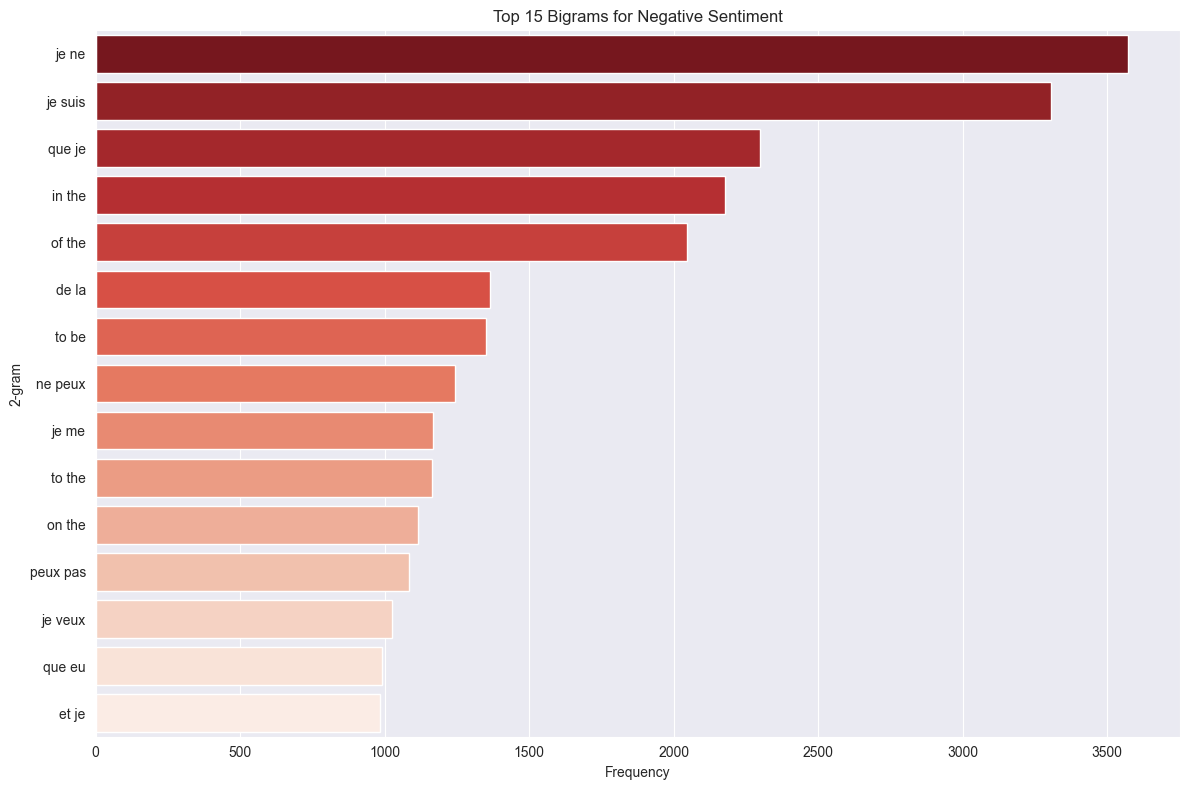

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_3679/3954697750.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'), legend=False)


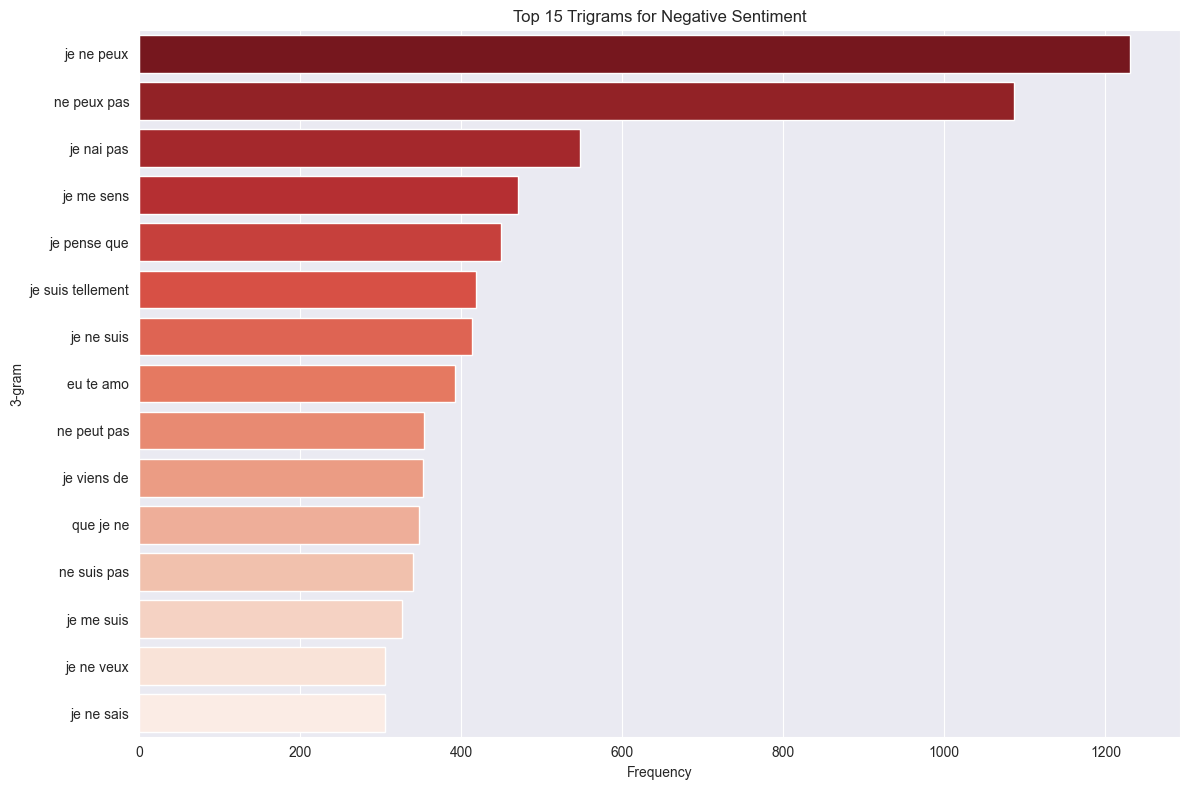


Processing Positive sentiment for N-grams...


/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_3679/3954697750.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'), legend=False)


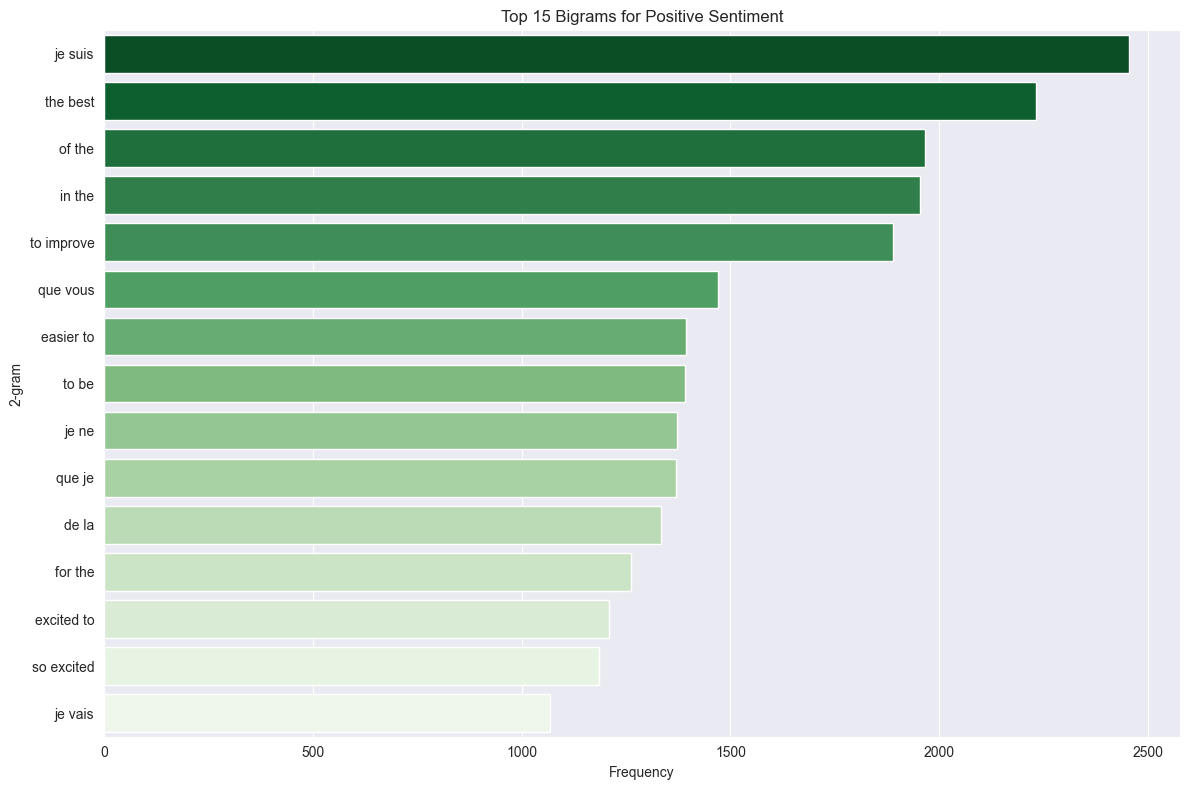

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_3679/3954697750.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'), legend=False)


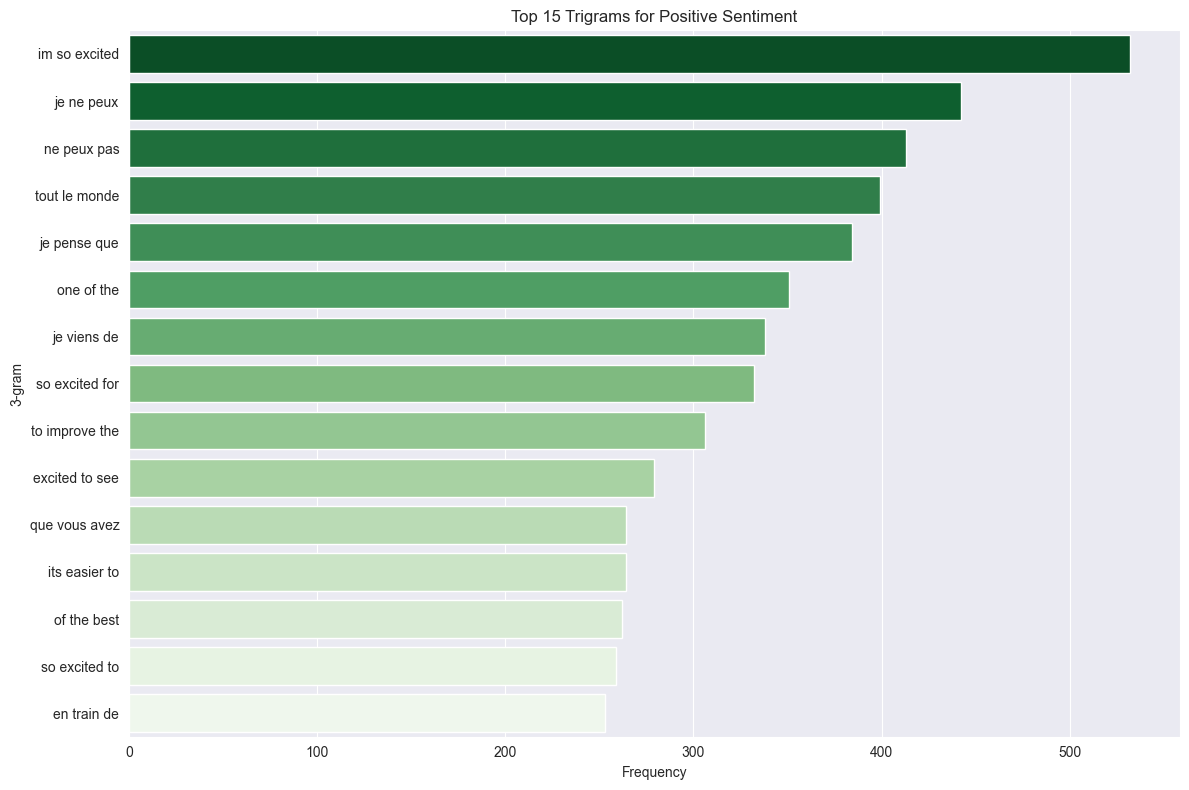

In [28]:
for label_code, sentiment_name in sentiment_labels.items():
    print(f"\nProcessing {sentiment_name} sentiment for N-grams...")
    sentiment_data = df_final_cleaned[df_final_cleaned['label'] == label_code]['text_clean'].dropna()
    # print(sentiment_data.head())
    corpus = sentiment_data.str.lower().str.replace(r'\s+', ' ', regex=True)
    # Plot Bigrams
    plot_top_n_grams(corpus,
                     title=f'Top 15 Bigrams for {sentiment_name} Sentiment',
                     n=2, top_k=15, sentiment_label_for_palette=sentiment_name)
    
    # Plot Trigrams
    plot_top_n_grams(corpus,
                     title=f'Top 15 Trigrams for {sentiment_name} Sentiment',
                     n=3, top_k=15, sentiment_label_for_palette=sentiment_name)


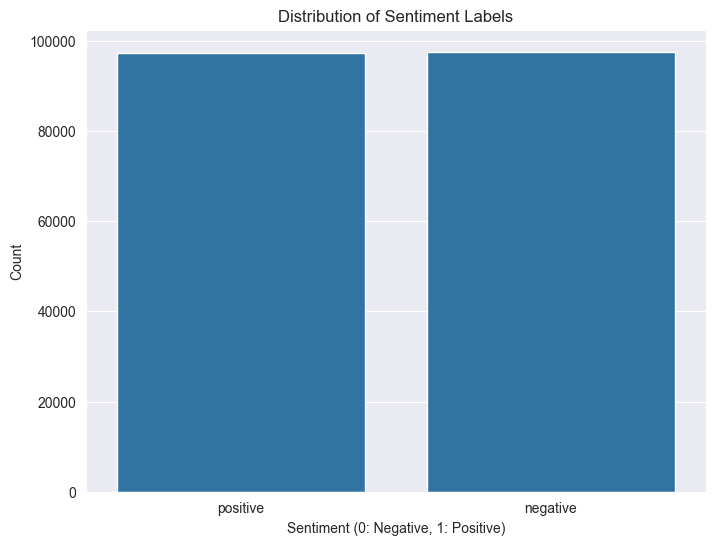

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_final_cleaned, x='label')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

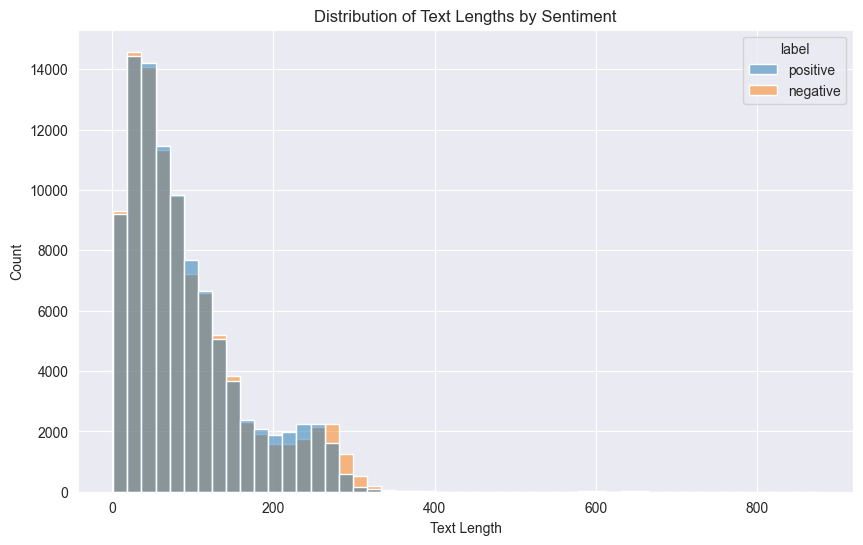

In [30]:
df_final_cleaned['text_clean_length'] = df_final_cleaned['text_clean'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final_cleaned, x='text_clean_length', hue='label', bins=50)
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

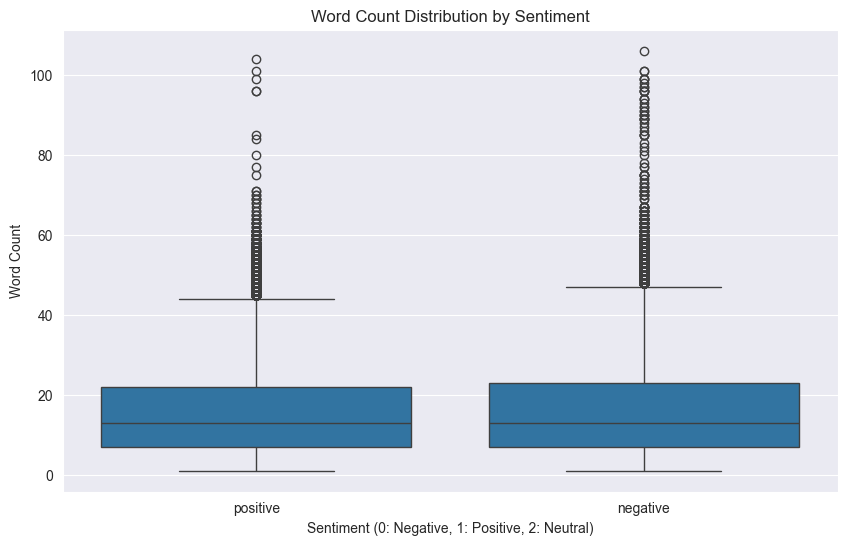

In [31]:
df_final_cleaned['word_count_cleaned'] = df_final_cleaned['text_clean'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final_cleaned, x='label', y='word_count_cleaned')
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Word Count')
plt.show()

In [32]:
output_directory = 'Datasets'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [33]:
output_file_path = os.path.join(output_directory, 'processed_final_195k.parquet')
df_final_cleaned.to_parquet(output_file_path, index=False)

# Training

In [34]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from evaluate  import load as load_metric

In [35]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA) for computations.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS) for computations.")
else:
    device = torch.device("cpu")
    print("Neither CUDA nor MPS available. Using CPU for computations.")

Using Apple Silicon GPU (MPS) for computations.


In [36]:
MODEL_ID = "xlm-roberta-base"
DATASET_PATH = '/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/Datasets/final/multilingual_sentiment_195k.csv'
# DATASET_PATH = '/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/Datasets/final/combined_no_neutral.csv'
TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label'
LANGUAGE_COLUMN = 'language'
NUM_LABELS = 2
langs = df["language"].unique().tolist()
LABEL2ID = {'negative': 0, 'positive': 1}
ID2LABEL = { 0:'negative', 1:'positive'}
LANG2ID = {lang: i for i, lang in enumerate(langs)}
ID2LANG = {v: k for k, v in LANG2ID.items()}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

### Reading Dataset Again:
- Not necessary to do this again. This notebook was a combination of several different datasets. Hence some steps are repeated

In [37]:
df = pd.read_csv(DATASET_PATH)
df.head()

,text,label,language
0,Que daora acho que meu título foi cancelado :)...,positive,pt
1,"Ok je ferai cela aussi, j'aurai une lecture de...",positive,fr
2,Mes cheveux sont éloquents! -___- je me sens c...,positive,fr
3,@cutesvantae @BTS_twt YAAAA :(((( eu amo demai...,negative,pt
4,Pourquoi pensez-vous que vous avez vécu en Aus...,negative,fr


In [38]:
# df = df.groupby(LABEL_COLUMN, group_keys=False).apply(
#     lambda x: x.sample(frac=0.02, random_state=42)
# ).reset_index(drop=True)
# print(f"Dataset reduced to 40% of each sentiment's original size. New shape: {df.shape}")

In [39]:
if TEXT_COLUMN not in df.columns or LABEL_COLUMN not in df.columns:
    raise ValueError(
        f"CSV must contain '{TEXT_COLUMN}' and '{LABEL_COLUMN}' columns."
    )

In [40]:
df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN], inplace=True)
df[LABEL_COLUMN] = df[LABEL_COLUMN].map(LABEL2ID)
# df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(int)
df[LANGUAGE_COLUMN] = df[LANGUAGE_COLUMN].map(LANG2ID).astype(int)
df.head()

,text,label,language
0,Que daora acho que meu título foi cancelado :)...,1,0
1,"Ok je ferai cela aussi, j'aurai une lecture de...",1,1
2,Mes cheveux sont éloquents! -___- je me sens c...,1,1
3,@cutesvantae @BTS_twt YAAAA :(((( eu amo demai...,0,0
4,Pourquoi pensez-vous que vous avez vécu en Aus...,0,1


In [41]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[LABEL_COLUMN]
)

In [42]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
print(train_dataset[0])
print(test_dataset[0])

{'text': '@canoglan he sil sil :)', 'label': 1, 'language': 0, '__index_level_0__': 139250}
{'text': "Regarder obama parler sur la sûreté cybernétique. Il n'a aucune idée de ce qu'il parle ..... je vais lui apprendre", 'label': 1, 'language': 1, '__index_level_0__': 121835}


In [51]:
train_dataset.column_names

['text', 'label', 'language', '__index_level_0__']

In [43]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [44]:
def tokenize_function(examples):
    """
    Tokenizes the text data. Padding and truncation are handled to ensure
    all sequences have the same length.
    """
    return tokenizer(
        examples[TEXT_COLUMN], padding="max_length", truncation=True, max_length=512
    )

In [45]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/155996 [00:00<?, ? examples/s]

Map:   0%|          | 0/39000 [00:00<?, ? examples/s]

In [46]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns([TEXT_COLUMN, 'language', '__index_level_0__'])
tokenized_test_dataset = tokenized_test_dataset.remove_columns([TEXT_COLUMN, 'language', '__index_level_0__'])

In [ ]:
t

In [47]:
print(F"using {device} for computations")

using mps for computations


In [48]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_LABELS,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
print(model.config)

XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



In [50]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)

In [52]:
peft_model = get_peft_model(model, peft_config)

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/.venv/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [53]:
peft_model.print_trainable_parameters()

trainable params: 1,181,954 || all params: 279,227,140 || trainable%: 0.4233


In [54]:
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

In [55]:
def compute_metrics(eval_pred):
    """
    Computes and returns a dictionary of metrics for evaluation.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [56]:
training_args = TrainingArguments(
    output_dir="./xml_roberta-mps-model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=2500,
    save_strategy="steps",
    save_steps=2500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # fp16 is not fully supported on MPS, so we disable it for stability.
    # PyTorch will automatically use mixed precision where available on MPS.
    fp16=False,
    save_safetensors=True,
    report_to="none"
)

In [57]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_3679/149036071.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [58]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
2500,0.292200,0.274888,0.901692,0.902275,0.901692,0.901655
5000,0.257200,0.294199,0.915462,0.915535,0.915462,0.915458
7500,0.218000,0.303308,0.914385,0.914401,0.914385,0.914384
10000,0.194700,0.288326,0.919000,0.919051,0.919000,0.918997
12500,0.165400,0.273729,0.918026,0.919077,0.918026,0.917976
15000,0.201700,0.259340,0.922641,0.922652,0.922641,0.922641
17500,0.224400,0.252626,0.920026,0.921648,0.920026,0.919946
20000,0.334000,0.205158,0.922641,0.922689,0.922641,0.922638
22500,0.266000,0.223559,0.925538,0.925600,0.925538,0.925535
25000,0.266200,0.277188,0.924410,0.924774,0.924410,0.924393


TrainOutput(global_step=38999, training_loss=0.2726000675761017, metrics={'train_runtime': 13665.2691, 'train_samples_per_second': 11.416, 'train_steps_per_second': 2.854, 'total_flos': 4.161068784741581e+16, 'train_loss': 0.2726000675761017, 'epoch': 1.0})

In [61]:
final_model_path = "./xlm_roberta_model"
trainer.save_model(final_model_path)

In [62]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.22919990122318268, 'eval_accuracy': 0.9300512820512821, 'eval_precision': 0.9300514245810078, 'eval_recall': 0.9300512820512821, 'eval_f1': 0.9300512921687855, 'eval_runtime': 1464.6964, 'eval_samples_per_second': 26.627, 'eval_steps_per_second': 6.657, 'epoch': 1.0}
